![Two data scientists working on a dashboard.](hr-image-small.png)

A common problem when creating models to generate business value from data is that the datasets can be so large that it can take days for the model to generate predictions. Ensuring that the dataset is stored as efficiently as possible is crucial for allowing these models to run on a more reasonable timescale without having to reduce the size of the dataset.

In this scenario, we are asked by a training provider called *Training Data Ltd.* to clean up one of their largest customer datasets. This dataset will eventually be used to predict whether their students are looking for a new job or not, information that they will then use to direct them to prospective recruiters.

We've been given access to `customer_train.csv`, which is a subset of their entire customer dataset, so weu can create a proof-of-concept of a much more efficient storage solution. The dataset contains anonymized student information, and whether they were looking for a new job or not during training:

| Column                   | Description                                                                      |
|------------------------- |--------------------------------------------------------------------------------- |
| `student_id`             | A unique ID for each student.                                                    |
| `city`                   | A code for the city the student lives in.                                        |
| `city_development_index` | A scaled development index for the city.                                         |
| `gender`                 | The student's gender.                                                            |
| `relevant_experience`    | An indicator of the student's work relevant experience.                          |
| `enrolled_university`    | The type of university course enrolled in (if any).                              |
| `education_level`        | The student's education level.                                                   |
| `major_discipline`       | The educational discipline of the student.                                       |
| `experience`             | The student's total work experience (in years).                                  |
| `company_size`           | The number of employees at the student's current employer.                       |
| `company_type`           | The type of company employing the student.                                       |
| `last_new_job`           | The number of years between the student's current and previous jobs.             |
| `training_hours`         | The number of hours of training completed.                                       |
| `job_change`             | An indicator of whether the student is looking for a new job (`1`) or not (`0`). |

project link:  https://projects.datacamp.com/projects/1600

## Requirements

1) Columns containing categories with only two factors must be stored as Booleans (`bool`).
2) Columns containing integers only must be stored as 32-bit integers (`int32`).
3) Columns containing floats must be stored as 16-bit floats (`float16`).
4) Columns containing nominal categorical data must be stored as the `category` data type.
5) Columns containing ordinal categorical data must be stored as *ordered categories*, and not mapped to numerical values, with an order that reflects the natural order of the column.
6) The DataFrame should be filtered to only contain students with *10 or more years* of experience at companies with *at least 1000 employees*, as their recruiter base is suited to more experienced professionals at enterprise companies.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset
ds_jobs = pd.read_csv("customer_train.csv")

# View the dataset
ds_jobs.head()

,student_id,city,city_development_index,gender,relevant_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,job_change
0,8949,city_103,0.920,Male,Has relevant experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevant experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevant experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevant experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevant experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


We'll look at each column one-by-one and determine the appropriate conversion.

In [2]:
# Create a copy of ds_jobs for transforming
ds_jobs_transformed = ds_jobs.copy()

init_memory = ds_jobs.memory_usage(index=False, deep=True)
print(f"total original memory usage before tranformation: {init_memory.sum()} bytes \n")
print(ds_jobs_transformed.info())

total original memory usage before tranformation: 12391577 bytes 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   student_id              19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevant_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  job_change              

## 1st row - `student_id`

The number of unique `student_id` values = the number of rows, so we just need to convert the original `int64` values to `int32`.

In [3]:
# 1st column - student_id
print(f"number of row of the data:         {ds_jobs_transformed.shape[0]}")
print(f"number of unique student_id value: {len(ds_jobs_transformed['student_id'].unique())}")

number of row of the data:         19158
number of unique student_id value: 19158


In [4]:
# since (student_id unique values) = (# of rows), we just need to convert from int64 to int32
ds_jobs_transformed['student_id'] = ds_jobs_transformed['student_id'].astype(np.int32)

### 2nd column - `city`

This variable is categorical with 123 levels. It is **nominal** since there is no natural order, so we just need to convert this to a nominal categorical variable per **requirement 4.**

In [5]:
# 2nd column - city
city_distribution = ds_jobs_transformed['city'].value_counts(normalize=True, dropna=False)
print(f"Total number of cities listed = {len(city_distribution)}. The top 5 most frequently listed are:")
print(city_distribution[:5])
print(city_distribution[-5:])

Total number of cities listed = 123. The top 5 most frequently listed are:
city
city_103    0.227320
city_21     0.141038
city_16     0.080019
city_114    0.069736
city_160    0.044107
Name: proportion, dtype: float64
city
city_129    0.000157
city_111    0.000157
city_121    0.000157
city_140    0.000052
city_171    0.000052
Name: proportion, dtype: float64


In [6]:
ds_jobs_transformed['city'] = ds_jobs_transformed['city'].astype("category")

## 3rd column - `city_development_index`

This column originally came in as `float64` and is distributed between 0.448 and 0.949 as shown in the following two cells. Since this appears to be a continuous variable (histogram below), we need to convert this column from `float64` to `float16` per **requirment 3.**

<class 'pandas.core.series.Series'>
RangeIndex: 19158 entries, 0 to 19157
Series name: city_development_index
Non-Null Count  Dtype  
--------------  -----  
19158 non-null  float64
dtypes: float64(1)
memory usage: 149.8 KB
None 

count    19158.000000
mean         0.828848
std          0.123362
min          0.448000
25%          0.740000
50%          0.903000
75%          0.920000
max          0.949000
Name: city_development_index, dtype: float64


<Axes: >

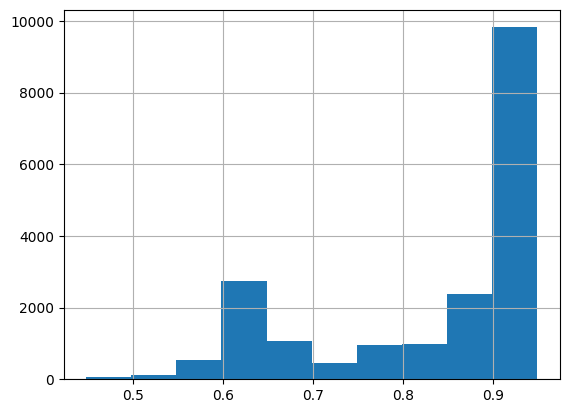

In [7]:
print(ds_jobs_transformed["city_development_index"].info(), "\n")
print(ds_jobs_transformed["city_development_index"].describe())
ds_jobs_transformed["city_development_index"].hist()  # these look like they really are floats, so convert to float16

In [8]:
ds_jobs_transformed["city_development_index"] = ds_jobs_transformed["city_development_index"].astype(np.float16)
ds_jobs_transformed.dtypes

student_id                   int32
city                      category
city_development_index     float16
gender                      object
relevant_experience         object
enrolled_university         object
education_level             object
major_discipline            object
experience                  object
company_size                object
company_type                object
last_new_job                object
training_hours               int64
job_change                 float64
dtype: object

## 4th column - `gender`

This column comes in originally as a string (`object`). The second largest category are missing values at 23.5%

The `Male` category makes up 69% of the entries. The `Female` category makes up about 6.5% and `Other` makes up less tha 0.1%. Since this has 3 level and no obvious order, we need to convert this to a *nominal* categorical column per **requirement 4.**

In [9]:
ds_jobs_transformed['gender'].value_counts(normalize=True, dropna=False)

gender
Male      0.690103
NaN       0.235306
Female    0.064621
Other     0.009970
Name: proportion, dtype: float64

In [10]:
ds_jobs_transformed['gender'] = ds_jobs_transformed['gender'].astype("category")

## 5th column - `relevant_experience`

This column comes in originally as a string (`object`). There are only two values: `Has relevant experience` and `No relevant experience`, so this is a binary variable which falls under **requirement 1.**  Thinking in terms of modeling this data, it makes the most sense to map `Has relevant experience` to 1 or *True* and `No relevant experience` to 0 or *False*.

In [11]:
print(ds_jobs["relevant_experience"].value_counts(dropna=False), "\n")  # no missing values in this col
# map 1 to having experience, 0 to not having experience
ds_jobs_transformed["relevant_experience"] = np.where(
    ds_jobs_transformed["relevant_experience"].str.contains("Has", regex=False), 1, 0).astype(bool)
ds_jobs_transformed["relevant_experience"].value_counts()

relevant_experience
Has relevant experience    13792
No relevant experience      5366
Name: count, dtype: int64 



relevant_experience
True     13792
False     5366
Name: count, dtype: int64

## 6th column - `enrolled_university`

This variable is categorical with three levels: `no_enrollment`, `Part time course` and `Full time course`. If we think in terms of *degree of enrollment*, then these categories could be considered ordinal is the following sense:

`no_enrollment` < `Part time course` < `Full time course`

Under these assumptions, the conversion will be governed by **requirement 5.**

In [12]:
print(ds_jobs_transformed['enrolled_university'].value_counts(dropna=False), "\n")  # a few NaNs...

ds_jobs_transformed.groupby(by=['enrolled_university'], observed=True)['enrolled_university'].count()  # BEFORE conversion

enrolled_university
no_enrollment       13817
Full time course     3757
Part time course     1198
NaN                   386
Name: count, dtype: int64 



enrolled_university
Full time course     3757
Part time course     1198
no_enrollment       13817
Name: enrolled_university, dtype: int64

In [13]:
# convert to ordinal categorical
ds_jobs_transformed["enrolled_university"] = ds_jobs_transformed["enrolled_university"].astype("category")
ds_jobs_transformed["enrolled_university"] = ds_jobs_transformed["enrolled_university"].cat.reorder_categories(
    new_categories = ['no_enrollment', 'Part time course', 'Full time course'],
    ordered=True
)

ds_jobs_transformed.groupby(by=['enrolled_university'], observed=True)['enrolled_university'].count() # AFTER conversion

enrolled_university
no_enrollment       13817
Part time course     1198
Full time course     3757
Name: enrolled_university, dtype: int64

## 7th column - `education_level`

This is another ordinal categorical variable, but with five levels. If we think in terms of *amount of education*, then these categories could be considered ordinal is the following sense:

`Primary School` < `High School` < `Graduate` < `Masters` < `Phd`

Under these assumptions, the conversion will be governed by **requirement 5.**

In [14]:
ds_jobs_transformed['education_level'].value_counts(dropna=False)

education_level
Graduate          11598
Masters            4361
High School        2017
NaN                 460
Phd                 414
Primary School      308
Name: count, dtype: int64

In [15]:
print(ds_jobs_transformed.groupby(by=['education_level'], observed=True)['education_level'].count(), "\n") # BEFORE conversion

# convert to ordinal categorical
ds_jobs_transformed["education_level"] = ds_jobs_transformed["education_level"].astype("category")
ds_jobs_transformed["education_level"] = ds_jobs_transformed["education_level"].cat.reorder_categories(
    new_categories = ['Primary School', 'High School', 'Graduate', 'Masters', 'Phd'],
    ordered=True
)

print(ds_jobs_transformed.groupby(by=['education_level'], observed=True)['education_level'].count()) # AFTER conversion

education_level
Graduate          11598
High School        2017
Masters            4361
Phd                 414
Primary School      308
Name: education_level, dtype: int64 

education_level
Primary School      308
High School        2017
Graduate          11598
Masters            4361
Phd                 414
Name: education_level, dtype: int64


## 8th column - `major_discipline`

This is a categorical variable with six levels and no obvious order. So, we need to convert this to a *nominal* categorical column per **requirement 4.**

In [16]:
ds_jobs_transformed["major_discipline"].value_counts(dropna=False)  # lot of NaNs

major_discipline
STEM               14492
NaN                 2813
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: count, dtype: int64

In [17]:
ds_jobs_transformed["major_discipline"] = ds_jobs_transformed["major_discipline"].astype("category")

## 9th column - `experience`

This is another ordinal categorical variable, but with many levels. The level naturally order themselves from low values (less experience) to high values (more experience).

Under these assumptions, the conversion will be governed by **requirement 5.**

In [18]:
ordered_experience = ['<1', '1', '2', '3', '4', '5', '6', '7',
                      '8', '9', '10', '11', '12', '13', '14',
                      '15', '16', '17', '18', '19', '20', '>20']
print(ds_jobs_transformed.groupby(by=['experience'], observed=True)['experience'].count(), "\n") # BEFORE conversion

ds_jobs_transformed['experience'] = ds_jobs_transformed['experience'].astype('category')
ds_jobs_transformed['experience'] = ds_jobs_transformed['experience'].cat.reorder_categories(
    new_categories = ordered_experience,
    ordered=True
)

print(ds_jobs_transformed.groupby(by=['experience'], observed=True)['experience'].count()) # AFTER conversion

experience
1       549
10      985
11      664
12      494
13      399
14      586
15      686
16      508
17      342
18      280
19      304
2      1127
20      148
3      1354
4      1403
5      1430
6      1216
7      1028
8       802
9       980
<1      522
>20    3286
Name: experience, dtype: int64 

experience
<1      522
1       549
2      1127
3      1354
4      1403
5      1430
6      1216
7      1028
8       802
9       980
10      985
11      664
12      494
13      399
14      586
15      686
16      508
17      342
18      280
19      304
20      148
>20    3286
Name: experience, dtype: int64


## 10th column - `company_size`

Catigorical and ordinal

In [19]:
print(ds_jobs_transformed.groupby(by=['company_size'], observed=True)['company_size'].count(), "\n") # BEFORE conversion

ordered_company_size = ['<10', '10-49', '50-99', '100-499', '500-999', '1000-4999', '5000-9999', '10000+']
ds_jobs_transformed['company_size'] = ds_jobs_transformed['company_size'].astype('category')
ds_jobs_transformed['company_size'] = ds_jobs_transformed['company_size'].cat.reorder_categories(
    new_categories = ordered_company_size,
    ordered=True
)

print(ds_jobs_transformed.groupby(by=['company_size'], observed=True)['company_size'].count(), "\n") # AFTER conversion

company_size
10-49        1471
100-499      2571
1000-4999    1328
10000+       2019
50-99        3083
500-999       877
5000-9999     563
<10          1308
Name: company_size, dtype: int64 

company_size
<10          1308
10-49        1471
50-99        3083
100-499      2571
500-999       877
1000-4999    1328
5000-9999     563
10000+       2019
Name: company_size, dtype: int64 



## 11th column - `company_type`

Categorical, nominal

In [20]:
print(ds_jobs_transformed['company_type'].value_counts())

ds_jobs_transformed['company_type'] = ds_jobs_transformed['company_type'].astype('category')

company_type
Pvt Ltd                9817
Funded Startup         1001
Public Sector           955
Early Stage Startup     603
NGO                     521
Other                   121
Name: count, dtype: int64


## 12th column - `last_new_job`

Categorical, oridinal

In [21]:
print(ds_jobs_transformed.groupby(by=['last_new_job'], observed=True)['last_new_job'].count(), "\n") # BEFORE conversion

ordered_last_new_job = ['never', '1', '2', '3', '4', '>4']
ds_jobs_transformed['last_new_job'] = ds_jobs_transformed['last_new_job'].astype('category')
ds_jobs_transformed['last_new_job'] = ds_jobs_transformed['last_new_job'].cat.reorder_categories(
    new_categories = ordered_last_new_job,
    ordered = True
)

print(ds_jobs_transformed.groupby(by=['last_new_job'], observed=True)['last_new_job'].count(), "\n") # AFTER conversion

last_new_job
1        8040
2        2900
3        1024
4        1029
>4       3290
never    2452
Name: last_new_job, dtype: int64 

last_new_job
never    2452
1        8040
2        2900
3        1024
4        1029
>4       3290
Name: last_new_job, dtype: int64 



## 13th column - `training_hours`

Continuous variable that comes in as `int64`, so the conversion falls under **requirement 2.**

<Axes: >

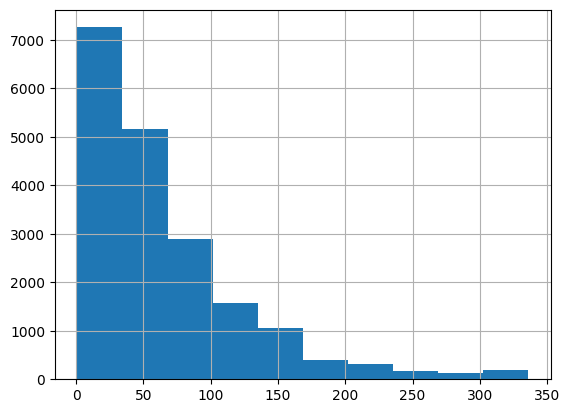

In [22]:
ds_jobs_transformed['training_hours'].hist()

In [23]:
ds_jobs_transformed['training_hours'] = ds_jobs_transformed['training_hours'].astype(np.int32)
ds_jobs_transformed.dtypes

student_id                   int32
city                      category
city_development_index     float16
gender                    category
relevant_experience           bool
enrolled_university       category
education_level           category
major_discipline          category
experience                category
company_size              category
company_type              category
last_new_job              category
training_hours               int32
job_change                 float64
dtype: object

## 14th columns - `job_change`

Categorical, binary: 1 = new job, 0 = not. This conversion falls under **requirement 1.**

In [24]:
ds_jobs_transformed["job_change"].value_counts()

job_change
0.0    14381
1.0     4777
Name: count, dtype: int64

In [25]:
# convert to bool as required
ds_jobs_transformed["job_change"] = ds_jobs_transformed["job_change"].astype(bool)
# check our final results
ds_jobs_transformed.dtypes

student_id                   int32
city                      category
city_development_index     float16
gender                    category
relevant_experience           bool
enrolled_university       category
education_level           category
major_discipline          category
experience                category
company_size              category
company_type              category
last_new_job              category
training_hours               int32
job_change                    bool
dtype: object

## Compare the difference before and after conversions

We see almost 2 orders of magnitude drop in size from the above conversions.

In [26]:
print(f"total original memory usage BEFORE tranformation: {init_memory.sum()} bytes")

after_conversion_memory = ds_jobs_transformed.memory_usage(index=False, deep=True)
print(f"total original memory usage AFTER tranformation:    {after_conversion_memory.sum()} bytes")

total original memory usage BEFORE tranformation: 12391577 bytes
total original memory usage AFTER tranformation:    419837 bytes


## Filter students

+ 10 or more years of experience
+ at companies with at least 1000 employees

In [27]:
# before filtering
ds_jobs_transformed.shape

(19158, 14)

In [28]:
ds_jobs_transformed_experience = ds_jobs_transformed.loc[ds_jobs_transformed['experience'] >= '10']
print(ds_jobs_transformed_experience.shape)
ds_jobs_transformed_experience.head()

(8682, 14)


,student_id,city,city_development_index,gender,relevant_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,job_change
0,8949,city_103,0.919922,Male,True,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,True
1,29725,city_40,0.775879,Male,False,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,False
4,666,city_162,0.767090,Male,True,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,False
5,21651,city_176,0.764160,NaN,True,Part time course,Graduate,STEM,11,NaN,NaN,1,24,True
7,402,city_46,0.762207,Male,True,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18,True


In [29]:
ds_jobs_transformed = ds_jobs_transformed_experience.loc[ds_jobs_transformed_experience['company_size'] >= '1000-4999']
print(ds_jobs_transformed.shape)
ds_jobs_transformed.head()

(2201, 14)


,student_id,city,city_development_index,gender,relevant_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,job_change
9,699,city_103,0.919922,NaN,True,no_enrollment,Graduate,STEM,17,10000+,Pvt Ltd,>4,123,False
12,25619,city_61,0.913086,Male,True,no_enrollment,Graduate,STEM,>20,1000-4999,Pvt Ltd,3,23,False
31,22293,city_103,0.919922,Male,True,Part time course,Graduate,STEM,19,5000-9999,Pvt Ltd,>4,141,False
34,26494,city_16,0.910156,Male,True,no_enrollment,Graduate,Business Degree,12,5000-9999,Pvt Ltd,3,145,False
40,2547,city_114,0.925781,Female,True,Full time course,Masters,STEM,16,1000-4999,Public Sector,2,14,False
